#Part5. [실습1] 보험료 예측



## 01. 데이터 소개 및 분석프로세스 수립
 → [강의자료]-[강의교안]-[Ch1.보험료 예측] 참고

In [88]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import pandas as pd
import numpy as np
import seaborn as sns
import missingno

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

## 02. 데이터 준비를 위한 EDA 및 전처리
#### 데이터는 [강의자료]-[실습데이터]의 [ch1_premium.csv] 를 이용합니다.
---
[EDA 체크리스트]
1. 어떤 질문을 풀거나 틀렸다고 증명하려고 하는가?
2. 중복된 항목은 있는가?
3. 어떤 종류의 데이터가 있으며 다른 데이터 타입들을 어떻게 다루려고 하는가?
4. 데이터에서 누락된 것이 있는지, 있다면 그것들을 어떻게 처리하려는가?
5. 이상치는 어디에 있는가? 관심을 가져야 할 데이터인가?
6. 변수 간 상관성이 있는가?
---

### 0. 데이터 불러오기



In [89]:
## 구글 드라이브 마운트가 필요할 시 주석 해제
# from google.colab import drive
# drive.mount('/content/drive')

In [90]:
############################################## 01. 실습 데이터 불러오기 #####################################################
data =pd.read_csv('data/ch3_premium.csv')

### 1. 어떤 질문을 풀거나 틀렸다고 증명하려고 하는가?
> 보험사 고객 정보를 통해 보험료 예측 모델을 생성하려고 한다.

> 간략하게 데이터 살피기

In [91]:
# 데이터의 모양 알아보기
print(data.shape)

(1338, 7)


In [92]:
# 데이터의 15개 행 데이터만 확인하기
print(data.head(15))

    age     sex     bmi  children smoker     region      charges
0    19  female  27.900         0    yes  southwest  16884.92400
1    18    male  33.770         1     no  southeast   1725.55230
2    28    male  33.000         3     no  southeast   4449.46200
3    33    male  22.705         0     no  northwest  21984.47061
4    32    male  28.880         0     no  northwest   3866.85520
5    31  female  25.740         0     no  southeast   3756.62160
6    46  female  33.440         1     no  southeast   8240.58960
7    37  female  27.740         3     no  northwest   7281.50560
8    37    male  29.830         2     no  northeast   6406.41070
9    60  female  25.840         0     no  northwest  28923.13692
10   25    male  26.220         0     no  northeast   2721.32080
11   62  female  26.290         0    yes  southeast  27808.72510
12   23    male  34.400         0     no  southwest   1826.84300
13   56  female  39.820         0     no  southeast  11090.71780
14   27    male     NaN  

*   고객ID 처럼 명백하게 보험료와 관계없는 것은 없는가?
*   컬럼 중 의미가 이해가지 않는 것은 없는가?
*   약어나 전문 용어로 되어 있는 것은 없는가?



### 2. 중복된 항목은 있는가?

In [93]:
# 중복된 항목 수 알아보기
###### 코드 작성 부분 시작 ######
#1. 중복 여부를 F,T,data로 []감싸면 중복된 행들만 추출
len(data[data.duplicated()])
###### 코드 작성 부분 마침 ######

1

In [94]:
# True에 해당하는 행만 선택됨
data[data.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [95]:
# 중복된 항목 확인
###### 코드 작성 부분 시작 ######
#keep 중복된 행을 식별할 때 어떤 방식으로 처리할지
#keep=False 옵션은 모든 중복된 행을 선택
data[data.duplicated(keep=False)].sort_values(by=list(data.columns))
###### 코드 작성 부분 마침 ######

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [96]:
# 중복된 항목 제거
###### 코드 작성 부분 시작 ######
# ignore_index 인덱스를 재설정하여 중복 행 제거 후 DataFrame의 인덱스를 0부터 순차적으로 다시 지정
data.drop_duplicates(keep='first',inplace=True,ignore_index=True)
###### 코드 작성 부분 마침 ######

### 3. 어떤 종류의 데이터가 있으며 다른 데이터 타입들을 어떻게 다루려고 하는가?

> 총 컬럼 수와 컬럼별 데이터 타입 확인

In [97]:
# 데이터 컬럼 이름/타입 정보 확인하기
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1332 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB
None


In [98]:
# 데이터 타입별 컬럼 수 확인하기
###### 코드 작성 부분 시작 ######
#  컬럼의 Dtype 확인 reset_index()를 통해 인덱스를 재설정
dtype_data = data.dtypes.reset_index()
dtype_data.columns = ["Count", "Column Type"] # 컬럼명 변경 
dtype_data = dtype_data.groupby("Column Type").aggregate('count').reset_index()

print(dtype_data)
###### 코드 작성 부분 마침 ######

  Column Type  Count
0       int64      2
1     float64      2
2      object      3


*    숫자형 데이터 중 명백하게 포함할 의미가 없는 것은 없는가?
*    범주형 변수는 있는가?

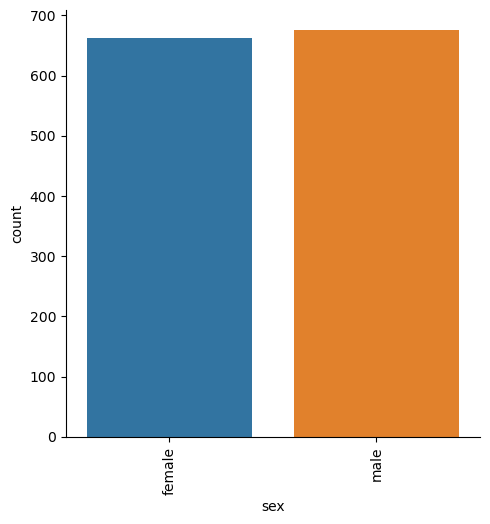

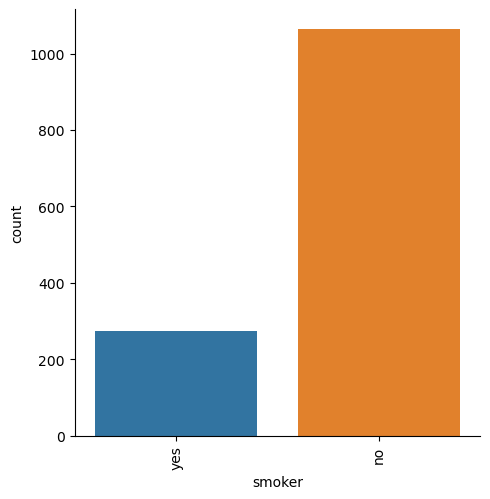

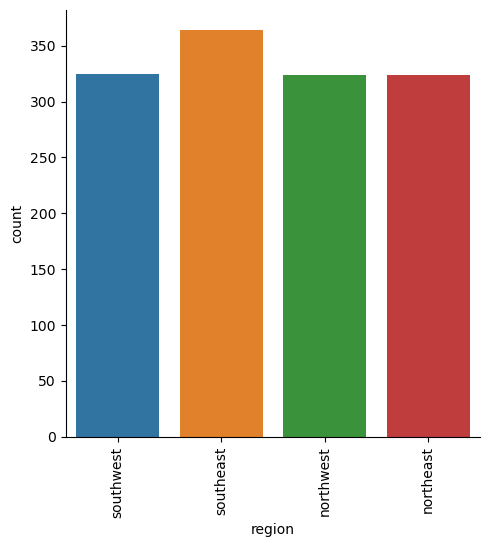

In [99]:
 # 범주형 변수별 개수 시각화
for col in data.select_dtypes(include=['object','category']).columns:
  #hue를 None으로 설정하여 추가적인 분리를 하지 않습니다
  #kind 시각화 유형을 지정하는 매개변수
  #"count": "bar"와 동일한 역할을 수행하며, 카테고리별로 데이터의 개수를 표시합니다.
  fig = sns.catplot(x=col, kind="count", data=data, hue=None)
  fig.set_xticklabels(rotation=90)
  plt.show()

In [100]:
# 범주형 데이터 컬럼별 유일한 값 개수 확인하기
###### 코드 작성 부분 시작 ######
#nunique() 함수를 호출하여 각 선택된 컬럼들에 대해 유일한 값의 개수를 확인
data.select_dtypes(include=['object','category']).nunique()
###### 코드 작성 부분 마침 ######

sex       2
smoker    2
region    4
dtype: int64

항목이 2개인 성별과, 흡연 여부는 LabelEncoder 를, 지역은 OneHotEncoder 를 사용하기로 한다.

> 범주형 변수 변환

In [101]:
## sklearn 의 LabelEncoder, OneHotEncoder 사용

In [102]:
## LabelEncoder : 각각의 범주를 서로 다른 정수로 맵핑
## 성별, 흡연 여부 컬럼은 Label Encoding 을 위해 ndarray 로 변환하여 준다
sex = data.iloc[:,1:2].values
smoker = data.iloc[:,4:5].values

### 성별 ###
# 1. LabelEncoder() 를 선언해주고
###### 코드 작성 부분 시작 ######
le =LabelEncoder()
###### 코드 작성 부분 마침 ######

# 2. 성별을 LabelEncoder 의 fit_transform 에 넣어준다
###### 코드 작성 부분 시작 ######
#sex 변수는 변환된 값들로 이루어진 1차원 배열(ndarray)이 됩니다.
# sex 변수는 변환된 값이 첫 번째 열에 반영된 2차원 배열(ndarray)이 됩니다.
sex[:,0] = le.fit_transform(sex[:,0])
sex = pd.DataFrame(sex)
sex.columns = ['sex']
print(sex)
###### 코드 작성 부분 마침 ######

# 3. dict 형으로 변환해주기
###### 코드 작성 부분 시작 ######
# zip() 함수를 사용하여 변환된 클래스와 원래 클래스를 매핑
# le.classes_ 는 원래의 클래스를 반환
# le.transform(le.classes_)는 숫자로 변환한 결과를 반환
le_sex_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("성별에 대한 Label Encoder 결과 : ")   
print(le_sex_mapping)
print(sex[:10])
###### 코드 작성 부분 마침 ######


     sex
0      0
1      1
2      1
3      1
4      1
...   ..
1332   1
1333   0
1334   0
1335   0
1336   0

[1337 rows x 1 columns]
성별에 대한 Label Encoder 결과 : 
{'female': 0, 'male': 1}
  sex
0   0
1   1
2   1
3   1
4   1
5   0
6   0
7   0
8   1
9   0


In [103]:
### 흡연 여부 ###
# 1. LabelEncoder() 를 선언해주고
###### 코드 작성 부분 시작 ######
le2 =LabelEncoder()
###### 코드 작성 부분 마침 ######

# 2. 흡연 여부를 LabelEncoder 의 fit_transform 에 넣어준다
###### 코드 작성 부분 시작 ######
smoker[:,0] = le2.fit_transform(smoker[:,0])
smoker=pd.DataFrame(smoker)
smoker.columns=["smoker"]
###### 코드 작성 부분 마침 ######

# 3. dict 형으로 변환해주기
###### 코드 작성 부분 시작 ######
le2_smoker_mapping=dict(zip(le2.classes_,le2.transform(le2.classes_)))
print("흡연에 대한 Label Encoder 결과 : ")
print(le2_smoker_mapping)
###### 코드 작성 부분 마침 ######

흡연에 대한 Label Encoder 결과 : 
{'no': 0, 'yes': 1}


In [104]:
## OneHot Encoder : 각각의 범주를 0과 1로 맵핑
## 지역 컬럼은 Label Encoding 을 위해 ndarray 로 변환하여 준다
region =data.iloc[:,5:6].values

### 지역 ###
# 1. OneHotEncoder() 를 선언해주고
###### 코드 작성 부분 시작 ######
one =OneHotEncoder()
###### 코드 작성 부분 마침 ######

# 2. 지역을 OneHotEncoder 의 fit_transform 에 넣어준다

###### 코드 작성 부분 시작 ######
#toarray() 메서드를 사용하여 배열 형태로 변환합니다.
region=one.fit_transform(region).toarray()
region =pd.DataFrame(region)
region.columns=['northeast', 'northwest', 'southeast', 'southwest']
print(region[:5])
###### 코드 작성 부분 마침 ######


   northeast  northwest  southeast  southwest
0        0.0        0.0        0.0        1.0
1        0.0        0.0        1.0        0.0
2        0.0        0.0        1.0        0.0
3        0.0        1.0        0.0        0.0
4        0.0        1.0        0.0        0.0


### 4. 데이터에서 누락된 것이 있는지, 있다면 그것들을 어떻게 처리하려는가?

> NULL 값이 포함된 컬럼 찾기 -> 각 컬럼의 평균값으로 채우기 (Imputation 또는 보간법)

In [105]:
count_nan=data.isnull().sum()
print(count_nan)

age         0
sex         0
bmi         5
children    0
smoker      0
region      0
charges     0
dtype: int64


In [106]:
count_nan=data.isnull().sum()
print(count_nan [count_nan>0])

bmi    5
dtype: int64


bmi    5
dtype: int64


<Axes: >

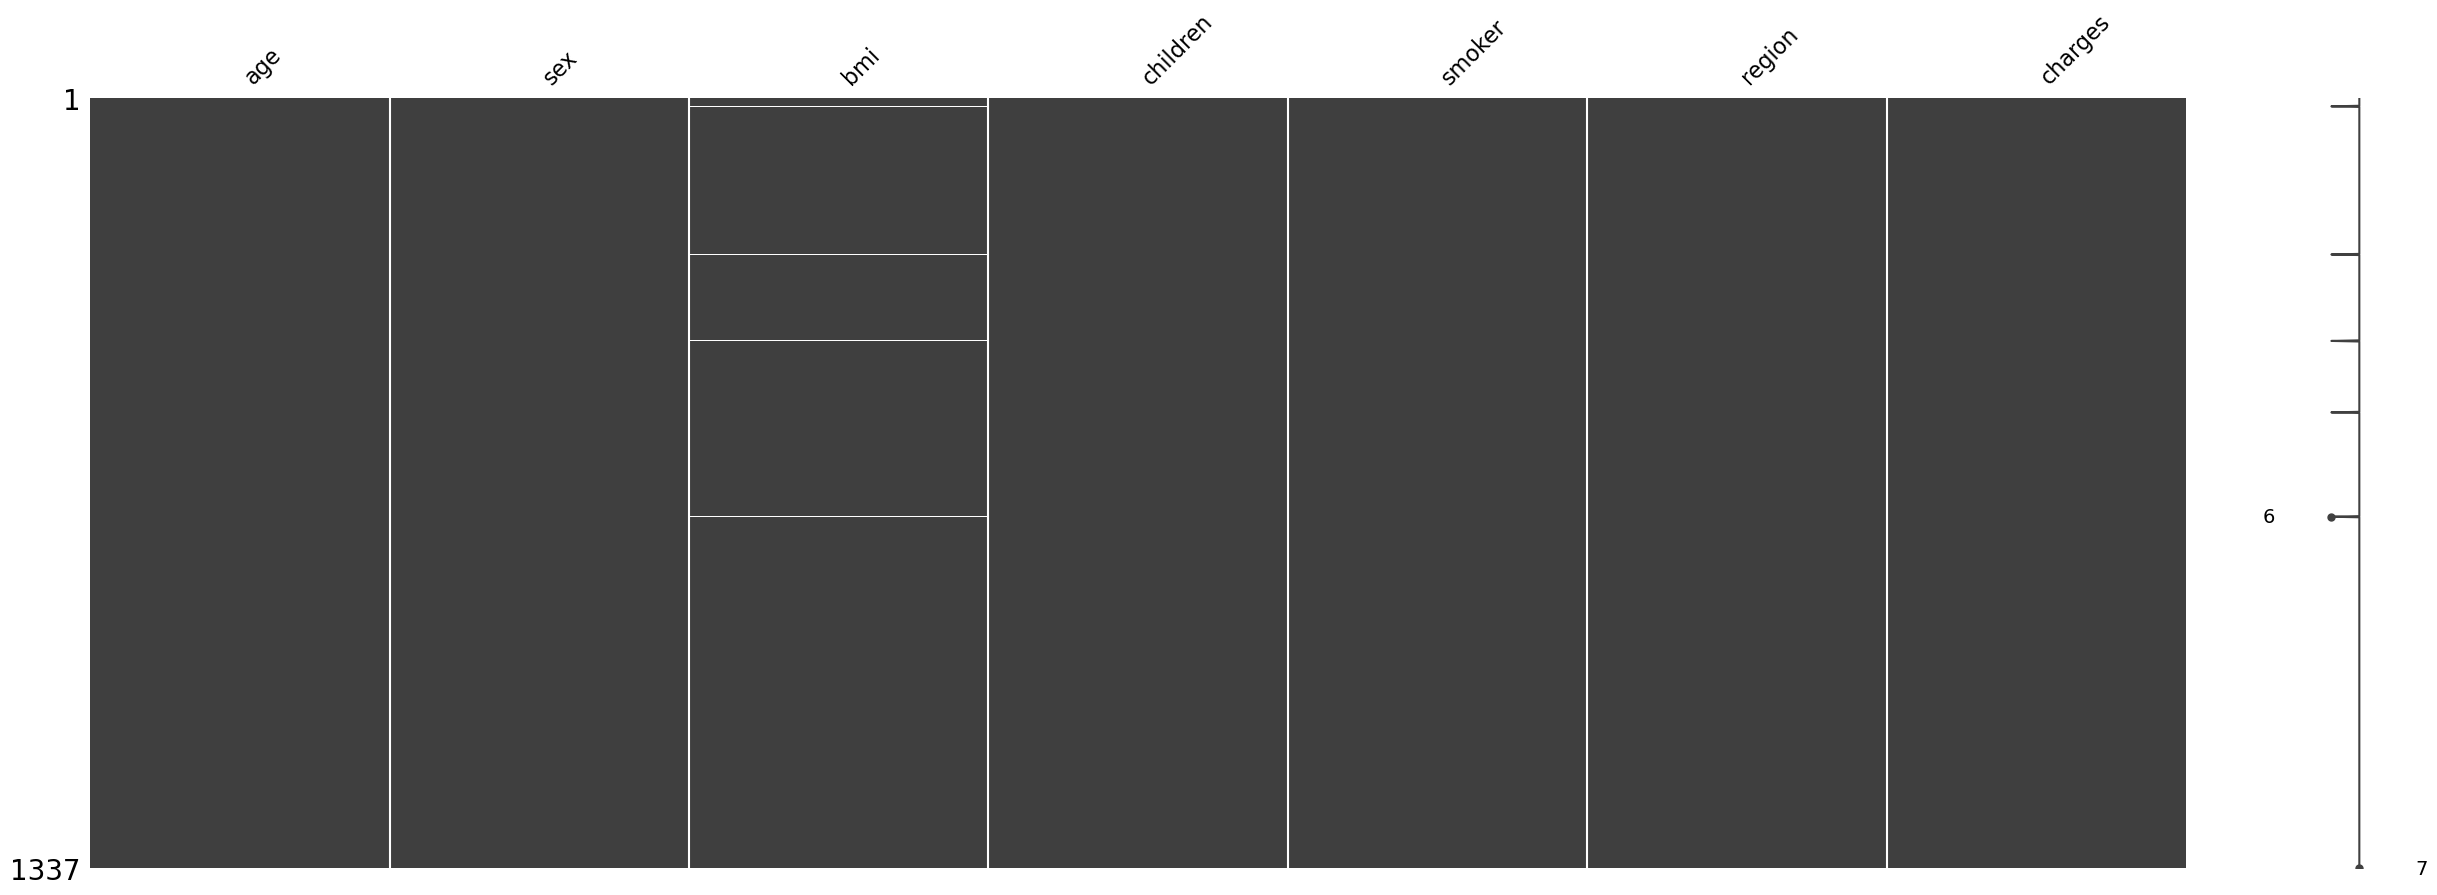

In [107]:
# 각 컬럼들에 몇 개의 NULL 값이 포함되어 있는지 확인
###### 코드 작성 부분 시작 ######
count_nan=data.isnull().sum()
print(count_nan [count_nan>0])
###### 코드 작성 부분 마침 ######


# missingno 패키지를 통해 시각화 확인
# missingno를 사용하면 결측 데이터가 어떻게 분포되어 있는지, 
# 어떤 열에서 결측치가 많은지, 결측치 간의 상관 관계 등을 시각적으로 확인할 수 있습니다. 
# 결측치 패턴을 시각화하여 데이터의 불완전성을 파악할 수 있다.
missingno.matrix(data, figsize=(30,10))

<Axes: >

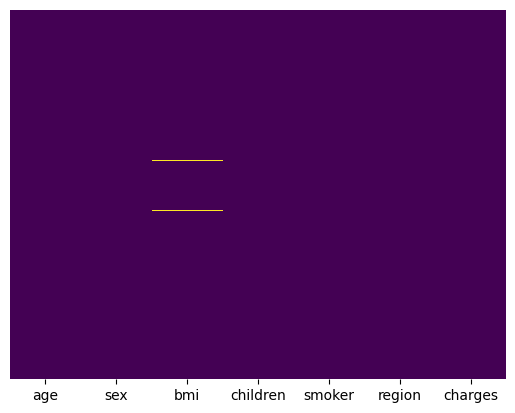

In [109]:
# seaborn 패키지 heatmap 을 통해 시각화 확인
#결측치를 히트맵으로 시각화
#cbar(cololr bar),yticklabels = y축의 레이블,cmap=히트맵의 색상 맵을
sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap='viridis')

<Axes: >

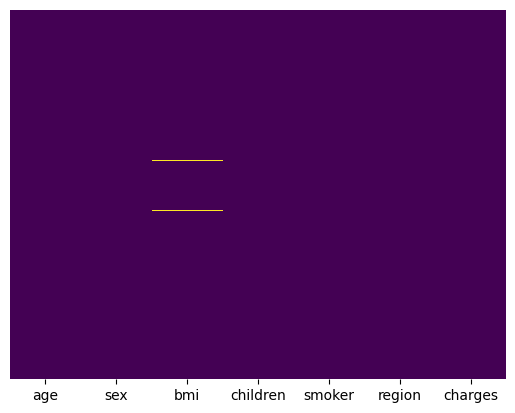

In [ ]:
sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

   age     sex    bmi  children smoker     region     charges
0   19  female  27.90         0    yes  southwest  16884.9240
1   18    male  33.77         1     no  southeast   1725.5523
2   28    male  33.00         3     no  southeast   4449.4620
Series([], dtype: int64)
Series([], dtype: int64)


<Axes: >

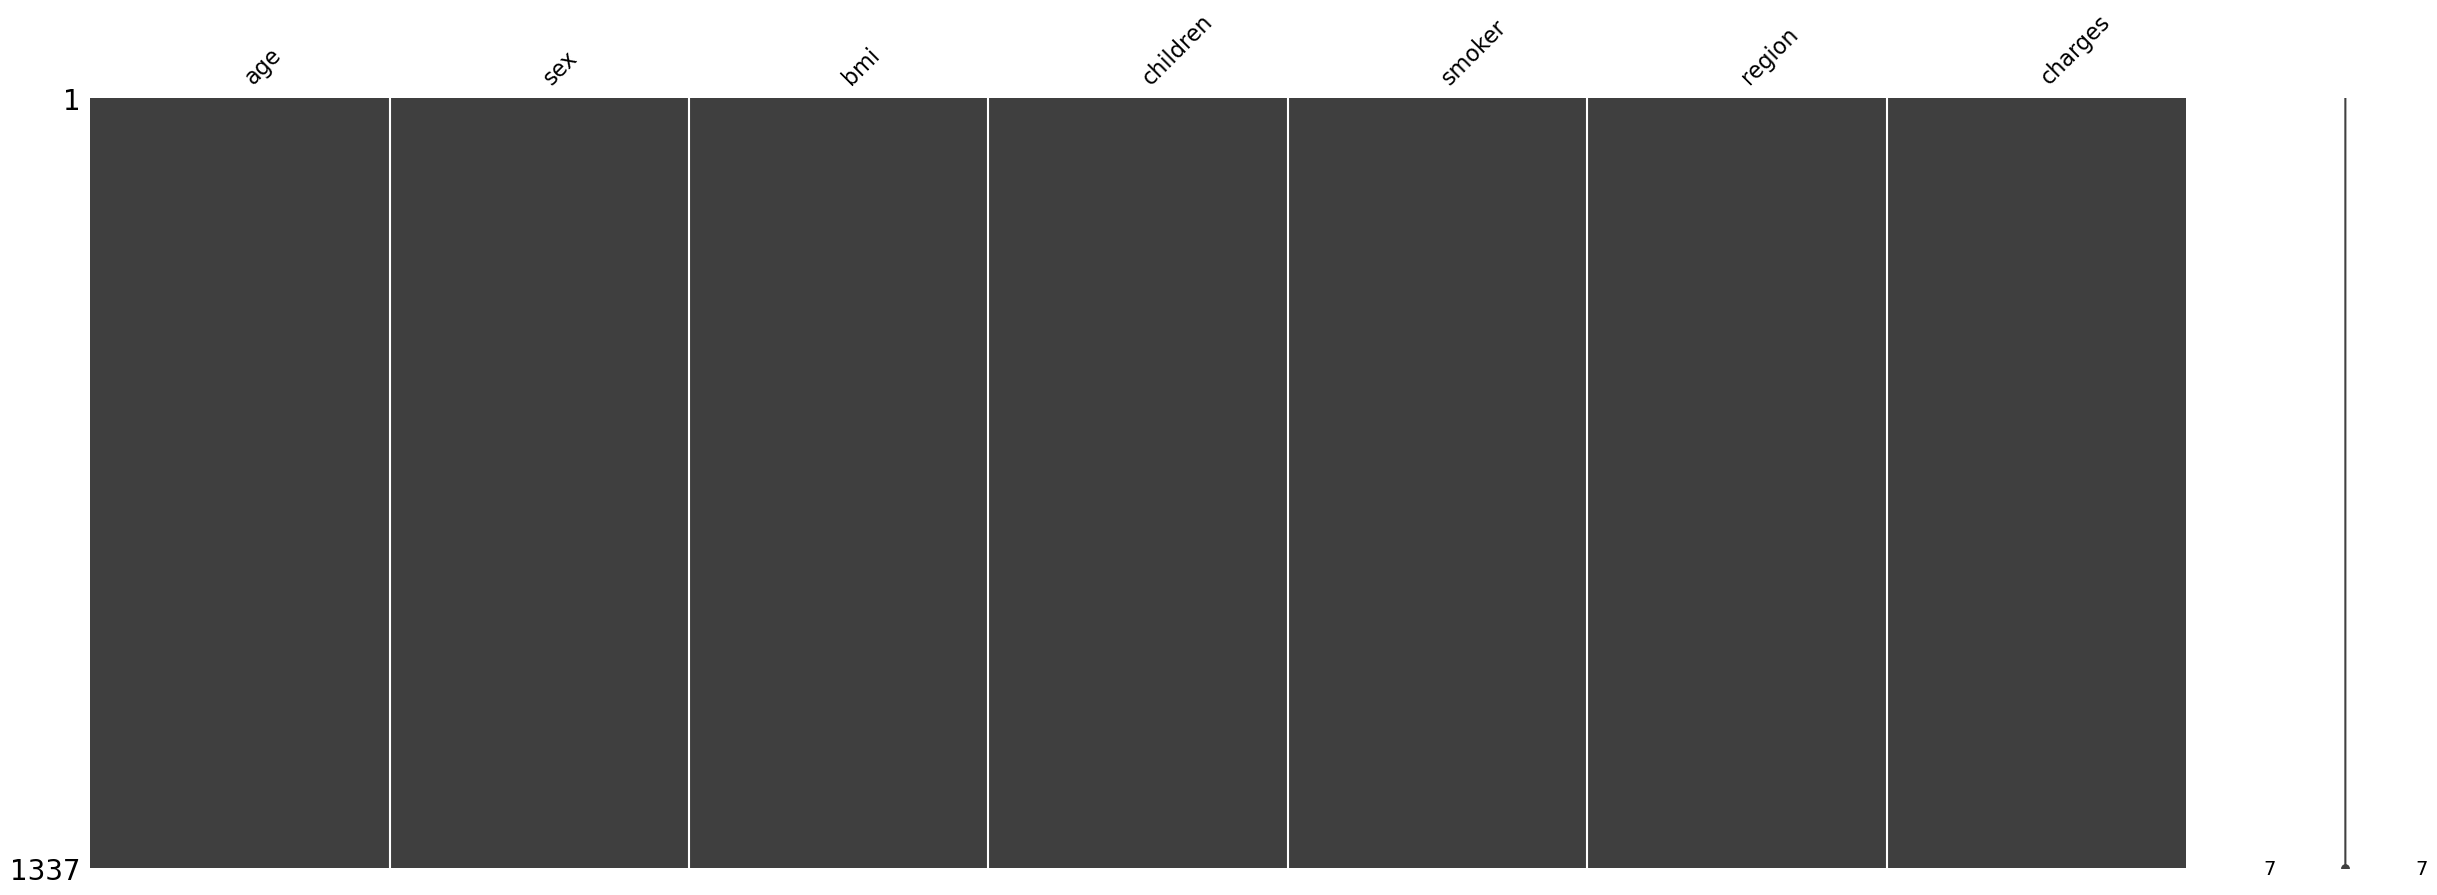

In [110]:
# NULL 값을 해당 컬럼의 평균값으로 대체하기
###### 코드 작성 부분 시작 ######
data['bmi'].fillna(data['bmi'].mean(),inplace=True)
print(data.head(3))
###### 코드 작성 부분 마침 ######

# 확인
###### 코드 작성 부분 시작 ######
count_nan=data.isnull().sum()
print(count_nan [count_nan>0])
###### 코드 작성 부분 마침 ######
print(count_nan[count_nan > 0])

# missingno 패키지를 통해 시각화 재확인
missingno.matrix(data, figsize=(30,10))

* 결측값 처리 참고 사이트 : https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4

### 5. 이상치는 어디에 있는가? 관심을 가져야 할 데이터인가?

> 숫자형 데이터별 요약 통계값 확인

In [111]:
# 데이터 컬럼별 요약 통계값 보기
summary=data.describe().T
summary


,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.658596,6.083657,15.9600,26.315,30.4000,34.60000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


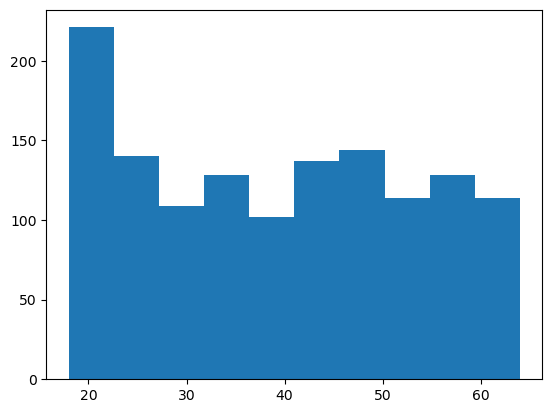

In [ ]:
# 데이터 개별 컬럼 히스토그램으로 확인하기
plt.hist(data.age)
plt.show()

> 숫자형 데이터 Skewness 확인

In [ ]:
# 데이터 컬럼 타입이 np.number 인 것만 가져오기
###### 코드 작성 부분 시작 ######
data_np=data.select_dtypes(include=np.number)
###### 코드 작성 부분 마침 ######

# 데이터 컬럼 타입이 np.number 인 컬럼 이름들 가져오기
l=data_np.columns.values
number_of_columns=4
number_of_rows = len(l)-1/number_of_columns

# 컬럼별 히스토그램 그리기
# l은 열(컬럼) 이름
for i in range(0,len(l)):
    sns.displot(data_np[l[i]],kde=True) # kde : kernel density


> 숫자형 데이터 Box Plot 시각화

In [ ]:
# 데이터 컬럼 타입이 np.number 인 컬럼들 가져오기
columns = data.select_dtypes(include=np.number).columns
figure = plt.figure(figsize=(20, 10))
figure.add_subplot(1, len(columns), 1)
for index, col in enumerate(columns):
    if index > 0:
        figure.add_subplot(1, len(columns), index + 1)
    sns.boxplot(y=col, data=data, boxprops={'facecolor': 'None'})
figure.tight_layout() # 자동으로 명시된 여백에 관련된 서브플롯 파라미터를 조정한다.
plt.show()

In [112]:
plt.figure(figsize=(20,20))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data_np[l[i]],color='green',orient='v')
    plt.tight_layout()

ValueError: Number of rows must be a positive integer, not 4.75

<Figure size 2000x2000 with 0 Axes>

> 범주형 데이터별 Violin Plot 시각화

In [ ]:
if len(data.select_dtypes(include=['object','category']).columns) > 0:
        for col_num in data.select_dtypes(include=np.number).columns:
            for col in data.select_dtypes(include=['object','category']).columns:
                fig = sns.catplot(x=col, y=col_num, kind='violin', data=data, height=5, aspect=2)
                fig.set_xticklabels(rotation=90)
                plt.show()

### 변수 간 상관성이 있는가?

> 숫자형 데이터 간 Pairwise 결합 분포 시각화

C:\Users\Admin\AppData\Local\Temp\ipykernel_25876\999530528.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap='Blues', annot=False)


<Axes: >

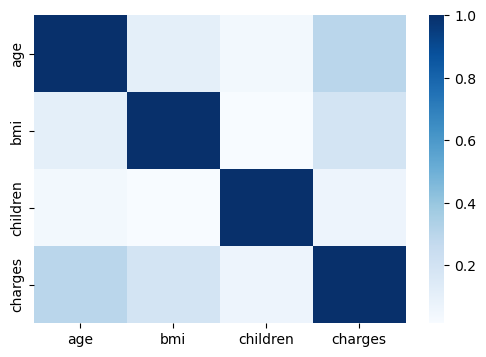

In [114]:
# Seaborn Heatmap 을 사용한 Correlation 시각화
plt.figure(figsize=(6,4))
# data.corr()은 데이터 프레임의 열 간 상관관계를 계산하고 반환
# annot=False는 히트맵에 각 셀에 숫자 값을 표시하지 않도록
sns.heatmap(data.corr(), cmap='Blues', annot=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_25876\1586249982.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cols = data.corr().nlargest(k, 'charges')['charges'].index


<Axes: >

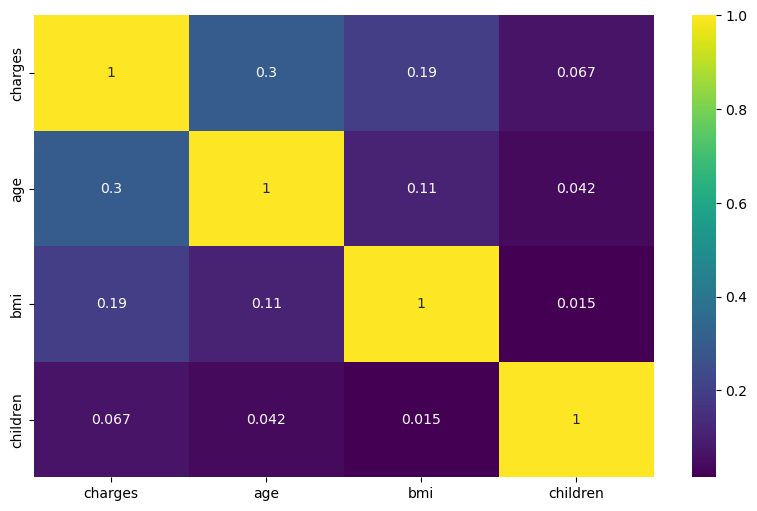

In [115]:
# 보험료 Correlation Matrix 시각화
k = 4 # Heatmap 에서 확인한 변수 개수
cols = data.corr().nlargest(k, 'charges')['charges'].index
cm = data[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

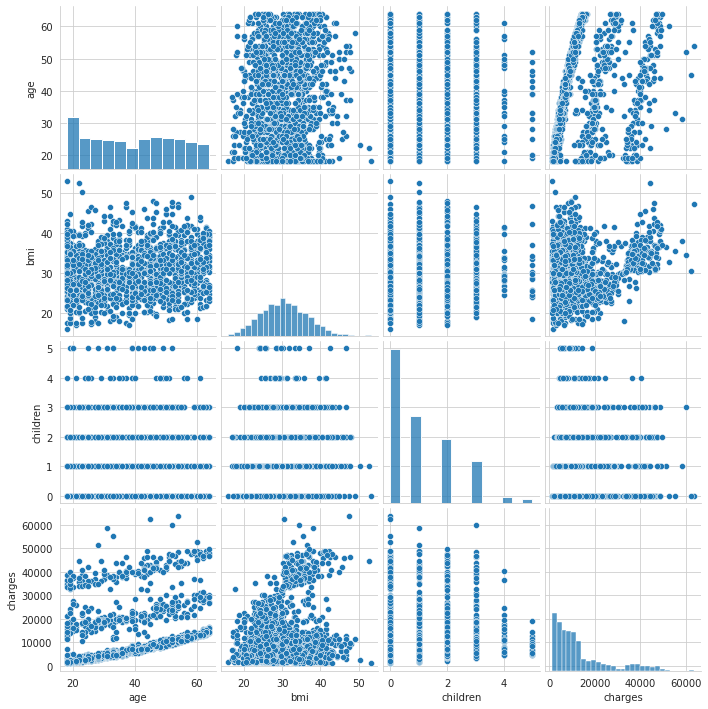

In [ ]:
# 숫자 변수형 컬럼들 간 Pairplot 그리기
sns.pairplot(data.select_dtypes(include=np.number))
plt.show()

> 범주형 데이터를 기준으로 추가한 시각화

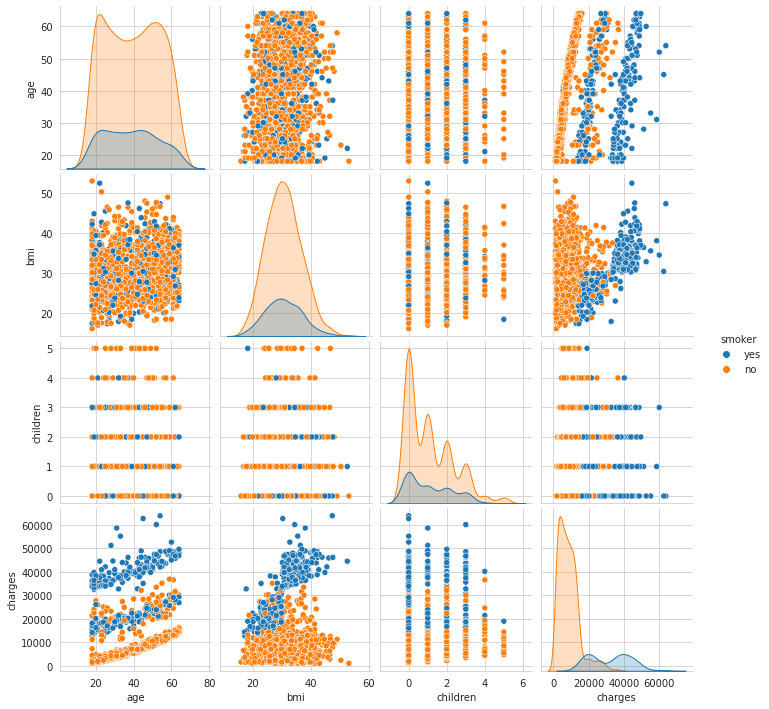

In [ ]:
# https://seaborn.pydata.org/examples/index.html
hue = 'smoker'
sns.pairplot(data.select_dtypes(include=np.number).join(data[[hue]]), hue=hue)
plt.show()

## 03. 다양한 Regression 을 활용한 보험료 예측
---

https://scikit-learn.org/stable/

### Training, Test 데이터 나누기

In [116]:
# 숫자형 데이터들만 copy() 를 사용하여 복사
X_num = data[['age', 'bmi', 'children']].copy()

# 변환했던 범주형 데이터들과 concat 을 사용하여 합치기
X_final = pd.concat([X_num, region, sex, smoker], axis = 1)

# 보험료 컬럼(charges)을 y 값으로 설정
y_final = data[['charges']].copy()

# train_test_split 을 사용하여 Training, Test 나누기 (Training:Test=2:1)
###### 코드 작성 부분 시작 ######
X_train,X_test,y_train,y_test =train_test_split(
   X_final,y_final, test_size=0.33,random_state=0 
)
###### 코드 작성 부분 마침 ######

In [ ]:
X_train[0:10]

,age,bmi,children,northeast,northwest,southeast,southwest,sex,smoker
905,27,32.585,3,1.0,0.0,0.0,0.0,1,0
2,28,33.000,3,0.0,0.0,1.0,0.0,1,0
405,52,38.380,2,1.0,0.0,0.0,0.0,0,0
481,49,37.510,2,0.0,0.0,1.0,0.0,1,0
338,50,32.300,1,1.0,0.0,0.0,0.0,1,1
356,46,43.890,3,0.0,0.0,1.0,0.0,1,0
1258,52,23.180,0,1.0,0.0,0.0,0.0,0,0
182,22,19.950,3,1.0,0.0,0.0,0.0,1,0
461,42,30.000,0,0.0,0.0,0.0,1.0,1,1
1058,32,33.820,1,0.0,1.0,0.0,0.0,1,0


In [117]:
X_test[0:10]

,age,bmi,children,northeast,northwest,southeast,southwest,sex,smoker
1247,18,39.820,0,0.0,0.0,1.0,0.0,0,0
609,47,29.370,1,0.0,0.0,1.0,0.0,0,0
393,49,31.350,1,1.0,0.0,0.0,0.0,1,0
503,19,30.250,0,0.0,0.0,1.0,0.0,1,1
198,51,18.050,0,0.0,1.0,0.0,0.0,0,0
820,26,17.670,0,0.0,1.0,0.0,0.0,1,0
31,18,26.315,0,1.0,0.0,0.0,0.0,0,0
1250,19,19.800,0,0.0,0.0,0.0,1.0,1,0
1298,19,25.745,1,0.0,1.0,0.0,0.0,0,0
1150,58,36.480,0,0.0,1.0,0.0,0.0,0,0


### Feature Scaling


*   다차원의 값들을 비교 분석하기 쉽게 만든다.
*   변수들 간의 단위 차이가 있을 경우 필요하다.
*   Overflow, Underflow 를 방지해준다.




https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler


In [118]:
## MinMaxScaler 를 사용하는 경우 : 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축될 수 있다

#n_scaler = MinMaxScaler()
#X_train = n_scaler.fit_transform(X_train.astype(np.float))
#X_test= n_scaler.transform(X_test.astype(np.float))

## StandardScaler 를 사용하는 경우 : 이상치가 있는 경우에는 균형 잡힌 결과를 보장하기 힘들다

###### 코드 작성 부분 시작 ######
std = StandardScaler()
#fit_transform은 학습 데이터에만 적용하고, transform은 학습된 모델을 사용
X_train=std.fit_transform(X_train.astype(np.float))
X_test =std.transform(X_test.astype(np.float))
###### 코드 작성 부분 마침 ######

## 그 외 - RobustScaler 를 사용하는 경우 : 이상치의 영향을 최소화한 기법. 중앙값과 IQR 을 사용하기 때문에 표준화 후 동일한 값을 더 넓게 분포시키게 된다.

C:\Users\Admin\AppData\Local\Temp\ipykernel_25876\1490840135.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train=std.fit_transform(X_train.astype(np.float))
C:\Users\Admin\AppData\Local\Temp\ipykernel_25876\1490840135.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test =std.transform(X_test.astype(np.float))


### Regression 절차 요약


*   ****Regression()
*   fit()
*   predict()
*   score()



### Linear Regression 적용

In [119]:
# fit model
###### 코드 작성 부분 시작 ######
lr =LinearRegression().fit(X_train,y_train)
###### 코드 작성 부분 마침 ######

# predict
###### 코드 작성 부분 시작 ######
X_train_predict =lr.predict(X_train)
X_test_predict =lr.predict(X_test)
###### 코드 작성 부분 마침 ######

# Score 확인
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print('lr train score %.3f, lr test score: %.3f' % (
lr.score(X_train,y_train),
lr.score(X_test, y_test)))


lr.coef_: [[3366.47112808 1725.71174012  603.99554217  268.25231121   14.31590009
   -13.39447522 -261.68008702  -71.08965939 9503.10176814]]
lr.intercept_: [13098.07379314]
lr train score 0.743, lr test score: 0.758


### Polynomial Regression 적용

In [120]:
poly = PolynomialFeatures(degree = 3)#degree = 다항 회귀 모델은 독립 변수의 제곱을 포함한 3차 다항식으로 모델링
X_poly = poly.fit_transform(X_final)

X_train,X_test,y_train,y_test = train_test_split(X_poly,y_final, test_size = 0.33, random_state = 0)

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# fit model
poly_lr = LinearRegression().fit(X_train,y_train)

# predict
y_train_pred = poly_lr.predict(X_train)
y_test_pred = poly_lr.predict(X_test)

# Score 확인
print('poly train score %.3f, poly test score: %.3f' % (
poly_lr.score(X_train,y_train),
poly_lr.score(X_test, y_test)))

poly train score 0.849, poly test score: 0.844


C:\Users\Admin\AppData\Local\Temp\ipykernel_25876\3277023680.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = sc.fit_transform(X_train.astype(np.float))
C:\Users\Admin\AppData\Local\Temp\ipykernel_25876\3277023680.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= sc.transform(X_test.astype(np.float))


### Support Vector Regression 적용

In [ ]:
svr = SVR(kernel='linear', C = 300)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# fit model
svr = svr.fit(X_train,y_train.values.ravel())
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# Score 확인
print('svr train score %.3f, svr test score: %.3f' % (
svr.score(X_train,y_train),
svr.score(X_test, y_test)))

svr train score 0.715, svr test score: 0.718


### RandomForest Regression 적용

In [121]:
###### 코드 작성 부분 시작 ######
forest = RandomForestRegressor().fit(X_train,y_train)
###### 코드 작성 부분 마침 ######

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# fit model
forest.fit(X_train,y_train.values.ravel())
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# Score 확인
print('forest train score %.3f, forest test score: %.3f' % (
forest.score(X_train, y_train),
forest.score(X_test, y_test)))

C:\Users\Admin\AppData\Local\Temp\ipykernel_25876\1100392068.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest = RandomForestRegressor().fit(X_train,y_train)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25876\1100392068.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = sc.fit_transform(X_train.astype(np.float))
C:\Users\Admin\AppData\Local\Temp\ipykernel_25876\1100392068.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any b

forest train score 0.975, forest test score: 0.841


### Decision Tree Regression 적용

In [ ]:
###### 코드 작성 부분 시작 ######
dt = DecisionTreeRegressor().fit()
###### 코드 작성 부분 마침 ######

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# fit model
dt = dt.fit(X_train,y_train.values.ravel())
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# Score 확인
print('dt train score %.3f, dt test score: %.3f' % (
dt.score(X_train,y_train),
dt.score(X_test, y_test)))

dt train score 0.999, dt test score: 0.701


### 다양한 모델 성능 종합 비교

In [ ]:
# 앞에서 만든 regressor 변수들과 라벨을 묶어서 하나의 리스트로 모으기
regressors = [(lr, 'Linear Regression'),
                (poly_lr, 'Polynomial Regression'),
                (svr, 'SupportVector Regression'),
                (forest, 'RandomForest Regression'),
                (dt, 'DecisionTree')]

# 각 regressor 변수들과 라벨 묶음을 차례로 fit -> predict -> score 로 처리해서 보여주기
for reg, label in regressors:
    print(80*'_', '\n')
    reg = reg.fit(X_train,y_train.values.ravel())
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    print(f'{label} train score %.3f, {label} test score: %.3f' % (
    reg.score(X_train,y_train),
    reg.score(X_test, y_test)))

________________________________________________________________________________ 

Linear Regression train score 0.742, Linear Regression test score: 0.756
________________________________________________________________________________ 

Polynomial Regression train score 0.742, Polynomial Regression test score: 0.756
________________________________________________________________________________ 

SupportVector Regression train score 0.715, SupportVector Regression test score: 0.718
________________________________________________________________________________ 

RandomForest Regression train score 0.974, RandomForest Regression test score: 0.842
________________________________________________________________________________ 

DecisionTree train score 0.999, DecisionTree test score: 0.701
